Prerequisite For RL compatibility

In [ ]:
!pip install gym

In [ ]:
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install colabgymrender
#Video Game play Prerequisites

In [ ]:
!pip install imageio==2.4.1
#Video Game play Prerequisites

In [ ]:
!pip install gym[atari]
#Video Game play Prerequisites

In [ ]:
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"
#Video Game play Prerequisites

In [ ]:
!pip install gym[accept-rom-license]

#Build a DQN for playing the Atari games

https://www.gymlibrary.dev/environments/atari/ms_pacman/ 

About MsPacMan Atari Game:

PacMan goal is to collect all of the pellets on the screen while avoiding the ghosts.

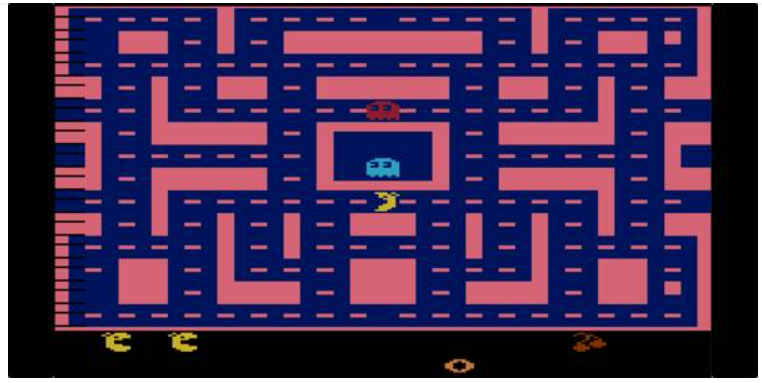

Actions

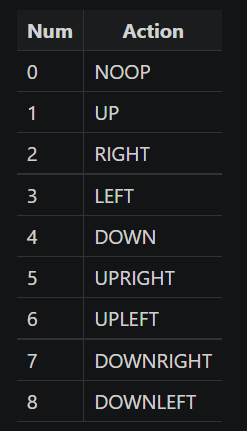



> In the Atari environment, the image of the game screen is the state of
the environment.

> we just feed the image of the game screen as
input to the DQN and it returns the Q values of all the actions in the
state.

> Since we are dealing with images, instead of using a vanilla deep neural network for approximating the Q value, we can use a convolutional neural network (CNN) since it is very effective for handling images.

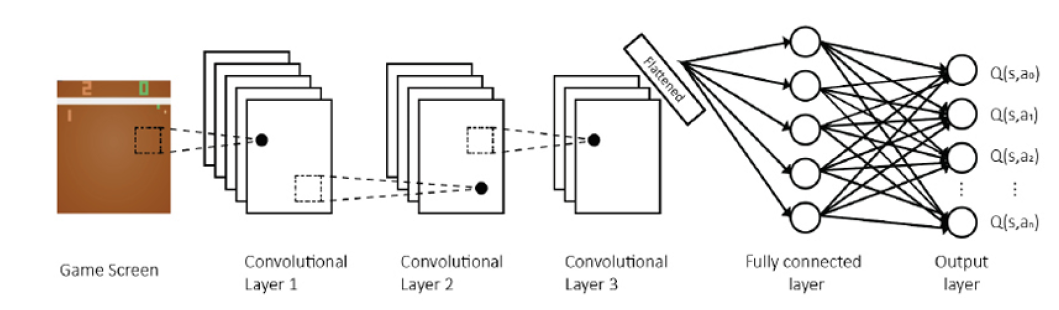










> Given the image of the game screen, the convolutional layers extract features from the image and produce a feature map.

> Flatten the feature map and feed the flattened feature map as input to the feedforward network.

> The feedforward network takes this flattened feature map as input and returns the Q values of all the actions in the state.

> Pooling operation should not be included because to understand the current game state

> A pooling operation is used to identify whether there is a object in the image such as Object detection irrespective of the position of the object.

> For example, in the Pong, we just don't want to classify if there is a ball on the game screen. We want to know the position of the ball so that we can make a better action. Thus, we don't include the pooling operation in our DQN architecture.













Import the necessary libraries

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.9.2


In [ ]:
import random
import gym
import numpy as np
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D
from tensorflow.keras.optimizers import Adam

Step 1: Create the Ms Pacman game environment using gym

In [ ]:
env = gym.make("ALE/MsPacman-v5")

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


In [ ]:
action_size = env.action_space.n
state_size_full_details = env.observation_space
state_size = env.observation_space.shape

In [ ]:
action_size

9

In [ ]:
state_size_full_details                

Box(0, 255, (210, 160, 3), uint8)

In [ ]:
# 0-255 (pixel values range for RGB)
# (210,160,3) - (Height,Width,RGB scale)

In [ ]:
state_size      

(210, 160, 3)

Step 2: Preprocess the game screen


> Feed the game state (image of the game screen) as an input to the DQN which is the convolutional neural network and it outputs the Q value of all the actions in the state.

> Directly feeding the raw game screen image is not efficient, since the raw game screen size will be 210 x 160 x 3. This will be computationally expensive

> To avoid this, we preprocess the game screen and then feed the preprocessed game screen to the DQN. First, we crop and resize the game screen image, convert the image to grayscale, normalize and then reshape the image to 88 x 80 x 1

> let's define a function called preprocess_state which takes the game state (image of the game screen) as an input and returns the preprocessed game state (image of the game screen)









In [ ]:
color = np.array([210, 164, 74]).mean()   # To give contrast on greyscale image
color

149.33333333333334

In [ ]:
def preprocess_state(state):  # type(state) is numpy.ndarray & state.shape >> (210,160,3)

    #crop and resize the image
    image = state[1:176:2, ::2]  # 1:176:2 >> 176/2 and ::2 >> 160/2 & image shape will be (88, 80, 3)

    #convert the image to greyscale
    image = image.mean(axis=2)   # image.shape >> (88,80) >> height and width of pixels.

    #improve image contrast i.e greyscale nature by loosing colour
    image[image==color] = 0  # image array elements where == color(i.e 149.33) will be replaced by 0.

    #normalize the image
    image = (image - 128) / 128 - 1  # Each array is subtracted by 128 / 127 and the product is substracted by 1
    
    #reshape the image
    image = np.expand_dims(image.reshape(88, 80, 1), axis=0)

    return image

Step 2: Defining the DQN class




> We learned that for playing atari games we use the convolutional neural network as the DQN which takes the image of the game screen as an input and returns the Q values.

> We define the DQN with three convolutional layers. The convolutional layers extract the features from the image and output the feature maps and then we flattened the feature map obtained by the convolutional layers and feed the flattened feature maps to the feedforward network (fully connected layer) which returns the Q value.

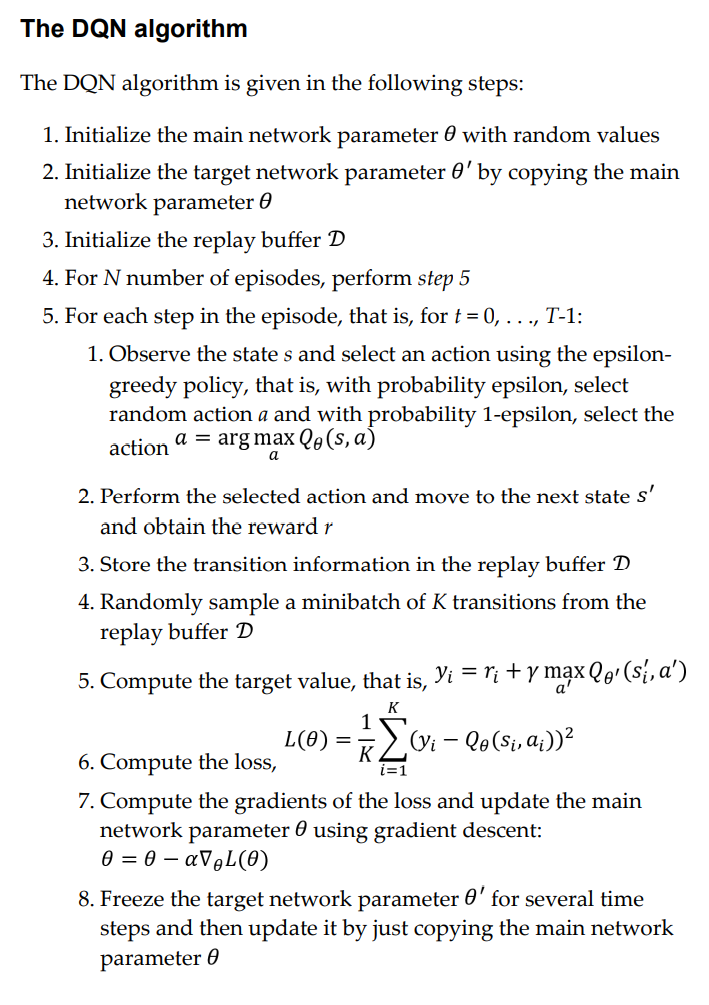

In [ ]:
class DQN:
    def __init__(self, state_size, action_size):  # init method to initialize instance variables
        
        #define the state size
        self.state_size = state_size
        
        #define the action size
        self.action_size = action_size
        
        #define the replay buffer
        self.replay_buffer = deque(maxlen=5000)  # Memory with 5000 storage
        
        #define the discount factor
        self.gamma = 0.9   # discount factor support to enumerate discounted maximum rewards
        
        #define the epsilon value
        self.epsilon = 0.8    # se exploration rate
        
        #define the update rate at which we want to update the target network
        self.update_rate = 10    
        
        #define the main network
        self.main_network = self.build_network()
        
        #define the target network
        self.target_network = self.build_network()
        
        #copy the weights of the main network to the target network
        self.target_network.set_weights(self.main_network.get_weights())

    #Let's define a function called build_network which is essentially our DQN. 

    def build_network(self):
        model = Sequential()
        model.add(Conv2D(32, (8, 8), strides=4, padding='same', input_shape=(88,80,1)))
        model.add(Activation('relu'))
        
        model.add(Conv2D(64, (4, 4), strides=2, padding='same'))
        model.add(Activation('relu'))
        
        model.add(Conv2D(64, (3, 3), strides=1, padding='same'))
        model.add(Activation('relu'))
        model.add(Flatten())


        model.add(Dense(512, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        
        model.compile(loss='mse', optimizer=Adam())

        return model

    #We learned that we train DQN by randomly sampling a minibatch of transitions from the
    #replay buffer. So, we define a function called store_transition which stores the transition information
    #into the replay buffer

    def store_transistion(self, state, action, reward, next_state, done):
        self.replay_buffer.append((state, action, reward, next_state, done))

    #We learned that in DQN, to take care of exploration-exploitation trade off, we select action
    #using the epsilon-greedy policy. So, now we define the function called epsilon_greedy
    #for selecting action using the epsilon-greedy policy.
    
    def epsilon_greedy(self, state):
        if random.uniform(0,1) < self.epsilon:
            return np.random.randint(self.action_size)
        
        Q_values = self.main_network.predict(state)
        
        return np.argmax(Q_values[0])

    #train the network
    def train(self, batch_size):
        
        #sample a mini batch of transition from the replay buffer
        minibatch = random.sample(self.replay_buffer, batch_size)
        
        #compute the Q value using the target network
        for state, action, reward, next_state, done in minibatch:

            if not done:
                target_Q = (reward + self.gamma * np.amax(self.target_network.predict(next_state)))
            else:
                target_Q = reward
           
            #compute the Q value using the main network 
            Q_values = self.main_network.predict(state)
          
            Q_values[0][action] = target_Q
            
            #train the main network
            self.main_network.fit(state, Q_values, epochs=1, verbose=1)
            
    #update the target network weights by copying from the main network
    def update_target_network(self):
        self.target_network.set_weights(self.main_network.get_weights())        

Training the network

Now, let's train the network. First, let's set the number of episodes we want to train the network:

In [ ]:
num_episodes = 10

In [ ]:
num_timesteps = 20    # Define the number of time steps

In [ ]:
batch_size = 8   #Define the batch size:

In [ ]:
#Instantiate the DQN class
dqn = DQN(state_size, action_size)

In [ ]:
done = False
time_step = 0

#for each episode
for i in range(num_episodes):
    print('Episode_starts:',i)
    #set return to 0
    Return = 0
    
    #preprocess the game screen
    state = preprocess_state(env.reset())

    #for each step in the episode
    for t in range(num_timesteps):
        
        #render the environment
        #env.render()
        
        #update the time step
        time_step += 1
        
        #update the target network
        if time_step % dqn.update_rate == 0:
            dqn.update_target_network()
        
        #select the action
        action = dqn.epsilon_greedy(state)
        
        #perform the selected action
        next_state, reward, done, _ = env.step(action)
        
        #preprocess the next state
        next_state = preprocess_state(next_state)
        
        #store the transition information
        dqn.store_transistion(state, action, reward, next_state, done)
        
        #update current state to next state
        state = next_state
        
        #update the return
        Return += reward
        
        #if the episode is done then print the return
        if done:
            print('Episode: ',i, ',' 'Return', Return)
            break
            
        #if the number of transistions in the replay buffer is greater than batch size
        #then train the network
        if len(dqn.replay_buffer) > batch_size:
            dqn.train(batch_size)

Episode_starts: 0
1/1 [==============================] - 0s 135ms/step


/usr/local/lib/python3.7/dist-packages/gym/utils/passive_env_checker.py:228: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  "Core environment is written in old step API which returns one bool instead of two. "


1/1 [==============================] - 0s 26ms/step - loss: 3.6149e-08
Episode_starts: 1
1/1 [==============================] - 0s 27ms/step - loss: 4.6549e-05
Episode_starts: 2
1/1 [==============================] - 0s 28ms/step - loss: 3.0123e-07
Episode_starts: 3
1/1 [==============================] - 0s 23ms/step - loss: 3.7848e-06
Episode_starts: 4
1/1 [==============================] - 0s 31ms/step - loss: 8.7496e-09
Episode_starts: 5
1/1 [==============================] - 0s 32ms/step - loss: 2.8409e-06
Episode_starts: 6
1/1 [==============================] - 0s 31ms/step - loss: 4.4282e-05
Episode_starts: 7
1/1 [==============================] - 0s 32ms/step - loss: 1.7687e-06
Episode_starts: 8
1/1 [==============================] - 0s 34ms/step - loss: 7.5099e-07
Episode_starts: 9
1/1 [==============================] - 0s 40ms/step - loss: 7.5839e-07
